# Benchmarking with and without OpenBLAS, on Dense Matrix

### Objective

Compares runtime and accuracy of computing traceinv using OpenBLAS versus not using OpenBLAS.

Matrix $\mathbf{A}$ is a sparse 3-band matrix with known analytic traceinv. Matrix is converted to **dense matrix** since OpenBLAS only operates on dense matrices.

Matrix size is varied over powers of two.

This notebook will plot

* Process time of each method.
* Accuracy of computing traceinv when compared with analytic solution for this matrix.

### Computation

Computes $\mathrm{trace}(\mathbf{A}^{-1})$ where $\mathbf{A} = \mathbf{C}^{\intercal} \mathbf{C}$ is a symmetric 3-band matrix and $\mathbf{C}$ is a 2-band matrix defined by

$$
    C_{ij} = 
    \begin{cases}
        \alpha, & i = j, \\
        \beta, & i+1 = j.
    \end{cases}
$$

The analytic value of $\mathrm{trace}(\mathbf{A}^{-1})$ is known by

$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - q^2 \frac{q^{2n} - 1}{q^2 - 1} \right),
$$
where $n$ is the size of the matrix and $q = \beta / \alpha \neq 1$. If $n \gg 1$
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - \frac{q^{2}}{1 - q^2} \right).
$$
If $q = 1$, then
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{n (n+1)}{2 \alpha^2}.
$$

### Consideratons

**parameters:**
* $\alpha = 2$, $\beta = 1$
* Using only SLQ, `minnum_samples` and `maxnum_samples` are fixed to 200. `lanczos_degree` is 50.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used.
* Each result is repeated 10 times and the wall time is averaged between these 10 repeats. However, only the last repeat is used to store the value of traceinv. This is becase if we average traceinv between these repeats, the number of samples would be 10*200, not 200. But, we onlt want to show the error of traceinv for 200 samples.
* Cholesky method is not repeated, since it is not a stochatic method and it runtime is more-or-less very similar in each test.
* The results are compared with the analytic value of traceinv given in the above.

**Notes:**

* Matrix is generated as sparse CSR. But then it is converted to dense matrix. This is becase OpenBLAS only performs dense matrix operations.
* Matrix size varies on powers of two.
* We cannot run 128-bit for OpenBLAS, becase it only supports 32-bit and 64-bit.

### How to run the code

#### 1. Run locally

Run `/benchmark/scripts/benchmark_openblas_dense.py` twice as follows:
   
1. Compile `imate` using OpenBLAS:
       
       export USE_CBLAS=1
       python setup.py install
       python ./benchmark_openblas_dense.py -o True     # Uses openblas
   
2. Compile `mate` without OpenBLAS:
       
       export USE_CBLAS=0
       python setup.py install
       python ./benchmark_openblas_dense.py -o False    # Does not use openblas  
          
The outputs are stored in

* `/benchnmark/pickle_results/benchmark_with_openblas_dense.pickle` for using OpenBLAS.
* `/benchnmark/pickle_results/benchmark_without_openblas_dense.pickle` for not using OpenBLAS.

#### 2. Run on cluster

To run on a cluster with SLURM:

    cd jobfiles
    sbatch jobfile_benchmark_openblas_dense.sh
   
When submitting the jobs on the cluster, make sure that the cpu is the same as the previous runs. For exaple, nodes on savio2 between `n027` and `n150` are *Intel Xeon E5-2670 v3*.

In [1]:
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

# Plot savefig settings
extension = 'pdf' # 'png'
transparent=True
dpi = 500

#matplotlib.rcParams['text.antialiased'] = True
#matplotlib.rcParams['lines.antialiased'] = True
#matplotlib.rcParams['patch.antialiased'] = True

In [2]:
benchmark_dir = '..'
cpu_results_filename = join(benchmark_dir, 'pickle_results', 'benchmark_without_openblas_dense.pickle')
cpu_blas_results_filename = join(benchmark_dir, 'pickle_results', 'benchmark_with_openblas_dense.pickle')


with open(cpu_results_filename, 'rb') as cpu_file:
    cpu_benchmark_result = pickle.load(cpu_file)
with open(cpu_blas_results_filename, 'rb') as cpu_blas_file:
    cpu_blas_benchmark_result = pickle.load(cpu_blas_file)
    
print('CPU Config:')
pp.pprint(cpu_benchmark_result['config'])
print('BPU BLAS Config:')
pp.pprint(cpu_blas_benchmark_result['config'])
print('')
print('CPU Matrix:')
pp.pprint(cpu_benchmark_result['matrix'])
print('CPU BLAS Matrix:')
pp.pprint(cpu_blas_benchmark_result['matrix'])
print('')
print('CPU Devices:')
pp.pprint(cpu_benchmark_result['devices'])
print('CPU BLAS Devices:')
pp.pprint(cpu_blas_benchmark_result['devices'])

print('')
cpu_data_results = cpu_benchmark_result['data_results']
cpu_blas_data_results = cpu_blas_benchmark_result['data_results']
print('CPU num data: %d' % len(cpu_data_results))
print('CPU BLAS num data: %d' % len(cpu_blas_data_results))

CPU Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'lanczos_degree': 50,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': 0,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'symmetric': True,
    'verbose': False}
BPU BLAS Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'lanczos_degree': 50,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': 0,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'symmetric': True,
    'verbose': False}

CPU Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'format': 'csr',
    'sizes': array([  256,   512,  1024,  2048,  4096,  8192, 16384]),
    'symmetric': True

In [3]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]

def analytic_traceinv(matrix):
    """
    Analytic trace of inverse of banded matrix.
    """
    
    sizes = matrix['sizes']
    alpha = matrix['band_alpha']
    beta = matrix['band_beta']
    symmetric = matrix['symmetric']
    
    if symmetric:
        
        if alpha == beta:
            M_traceinv = sizes * (sizes+1) / (2.0 * alpha**2)
        else:
            q = beta / alpha
            M_traceinv = numpy.zeros((sizes.size), dtype=float)
            
            for i in range(sizes.size):
                if sizes[i] < 200:
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * \
                        ( sizes - (q**2) *((q**(2.0*sizes) - 1.0) / (q**2 - 1.0)))
                else:
                    # Using assymptitic approximation of large sums
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * ( sizes - ((q**2) / (1.0 - q**2)))
            
    else:
        M_traceinv = sizes / alpha
        
    return M_traceinv

Plot saved to "benchmark_openblas_dense_time.pdf".


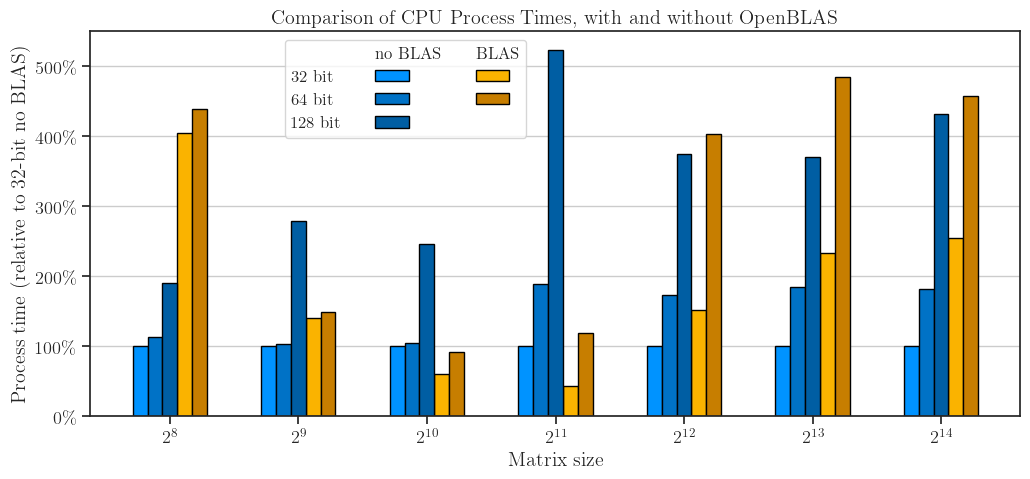

In [4]:
## Plotting Elapsed time vs Matrix Size

# Settings
plot_log = True
intel_color = ['#0093FF', '#0072C6', '#005EA3']    # corresponding to 32-bit, 64-bit, and 128-bit
intel_blas_color = ['#FAB300', '#C77E00']               # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                       # corresponding to 32-bit, 64-bit, and 128-bit

# Remove some data
cpu_data_results_ = cpu_data_results.copy()
cpu_blas_data_results_ = cpu_blas_data_results.copy()

#remove_indices = [0, 1, 2]
remove_indices = []

for index in remove_indices[::-1]:
    del cpu_data_results_[index]
    del cpu_blas_data_results_[index]

# Initialize arrays
num_data = len(cpu_data_results_)
num_types = 3   # correspondng to 32-bit, 64-bit, and 128-bit
matrix_size = numpy.zeros((num_data, ), dtype=int)
data_type = numpy.zeros((num_data, num_types), dtype=int)
cpu_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)

for data_index in range(num_data):

    cpu_data_result = cpu_data_results_[data_index]
    cpu_type_results = cpu_data_result['type_results']
    
    if data_index < len(cpu_blas_data_results_):
        cpu_blas_data_result = cpu_blas_data_results_[data_index]
        cpu_blas_type_results = cpu_blas_data_result['type_results']

    matrix_size[data_index] = cpu_type_results[0]['result']['info']['matrix']['size']

    # Iterate over 32-bit, 64-bit and 128-bit data
    for type_index in range(len(cpu_type_results)):

        cpu_type_result = cpu_type_results[type_index]
        data_type[data_index, type_index] = cpu_type_result['data_type']

        cpu_results = cpu_type_result['result']
        cpu_tot_wall_time[data_index, type_index] = cpu_results['info']['time']['tot_wall_time']
        cpu_alg_wall_time[data_index, type_index] = cpu_results['info']['time']['alg_wall_time']
        cpu_cpu_proc_time[data_index, type_index] = cpu_results['info']['time']['cpu_proc_time']
        
        if type_index < len(cpu_blas_type_results):
            cpu_blas_type_result = cpu_blas_type_results[type_index]
            cpu_blas_results = cpu_blas_type_result['result']

            if len(cpu_blas_results) > 0:
                cpu_blas_tot_wall_time[data_index, type_index] = \
                    cpu_blas_results['info']['time']['tot_wall_time']
                cpu_blas_alg_wall_time[data_index, type_index] = \
                    cpu_blas_results['info']['time']['alg_wall_time']
                cpu_blas_cpu_proc_time[data_index, type_index] = \
                    cpu_blas_results['info']['time']['cpu_proc_time']
            
    #sort_type_index = numpy.argsort(data_type[data_index, :])
    #data_type[data_index, :] = data_type[data_index, sort_type_index]
    #cpu_tot_wall_time[data_index, :] = cpu_tot_wall_time[data_index, sort_type_index]
    #cpu_alg_wall_time[data_index, :] = cpu_alg_wall_time[data_index, sort_type_index]
    #cpu_cpu_proc_time[data_index, :] = cpu_cpu_proc_time[data_index, sort_type_index]
    #cpu_blas_tot_wall_time[data_index, :] = cpu_blas_tot_wall_time[data_index, sort_type_index]
    #cpu_blas_alg_wall_time[data_index, :] = cpu_blas_alg_wall_time[data_index, sort_type_index]
    #cpu_blas_cpu_proc_time[data_index, :] = cpu_blas_cpu_proc_time[data_index, sort_type_index]
    

# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
abscissa = matrix_size
        
sorting_index = numpy.argsort(abscissa)
abscissa = abscissa[sorting_index]
cpu_alg_wall_time = cpu_alg_wall_time[sorting_index, :]
cpu_blas_alg_wall_time = cpu_blas_alg_wall_time[sorting_index, :]

            
# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

#width = 0.17
width = 0.08
#logsp = numpy.logspace(-width/1.55, width/1.55, 4)
logsp = numpy.logspace(-width/1.15, width/1.15, 5)
cpu_widths = logsp[:3]
cpu_blas_widths = logsp[3:]

for type_index in range(num_types):
    
    type_ = data_type[0][type_index]
    x = cpu_widths[type_index]*abscissa
    #ax.bar(x, 100.0 * cpu_alg_wall_time[:, type_index] / cpu_alg_wall_time[:, 0],
    ax.bar(x, 100.0 * cpu_cpu_proc_time[:, type_index] / cpu_cpu_proc_time[:, 0],
           width=width*x, edgecolor='black',
       color=intel_color[type_index], label='no BLAS ' + str(type_) + '-bit')
    
    if type_ != 128 and type_ != 0:
        x = cpu_blas_widths[type_index]*abscissa
        #ax.bar(x, 100.0 * cpu_blas_alg_wall_time[:, type_index] / cpu_alg_wall_time[:, 0],
        ax.bar(x, 100.0 * cpu_blas_cpu_proc_time[:, type_index] / cpu_cpu_proc_time[:, 0],
               width=width*x, edgecolor='black',
           color=intel_blas_color[type_index], label='BLAS ' + str(type_) + '-bit')

"""
for type_index in range(num_types):
   
    type_ = data_type[0, type_index]
    ax.plot(abscissa, cpu_alg_wall_time[:, type_index],
                markers[type_index], color=intel_color[type_index],
            label='no BLAS ' + str(type_) + '-bit')

    if type_ != 128:
        ax.plot(abscissa, cpu_blas_alg_wall_time[:, type_index], markers[type_index],
                color=intel_blas_color[type_index],
                label='BLAS ' + str(type_) + '-bit')
"""
        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
handles = [extra, extra, extra, extra,
           extra, handles[0], handles[2], handles[4], 
           extra, handles[1], handles[3], extra]
labels = ["", "32 bit", "64 bit", "128 bit",
          "no BLAS", "", "", "",
          "BLAS", "", "", ""]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2)
ax.legend(handles, labels, bbox_to_anchor=(0.2, 1), loc='upper left', ncol=3, handletextpad = -2,
          fontsize='small')
#ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)
    
plt.xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.set_xticks(matrix_size)

#ax.set_ylabel('Elapsed time (relative to 32-bit no BLAS)')
ax.set_ylabel('Process time (relative to 32-bit no BLAS)')
#ax.set_title('Elapsed Time v.s. Matrix Size')
ax.set_title('Comparison of CPU Process Times, with and without OpenBLAS')
ax.set_xlabel('Matrix size')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'benchmark_openblas_dense_time' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
           dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

Plot saved to "benchmark_openblas_dense_accuracy.pdf".


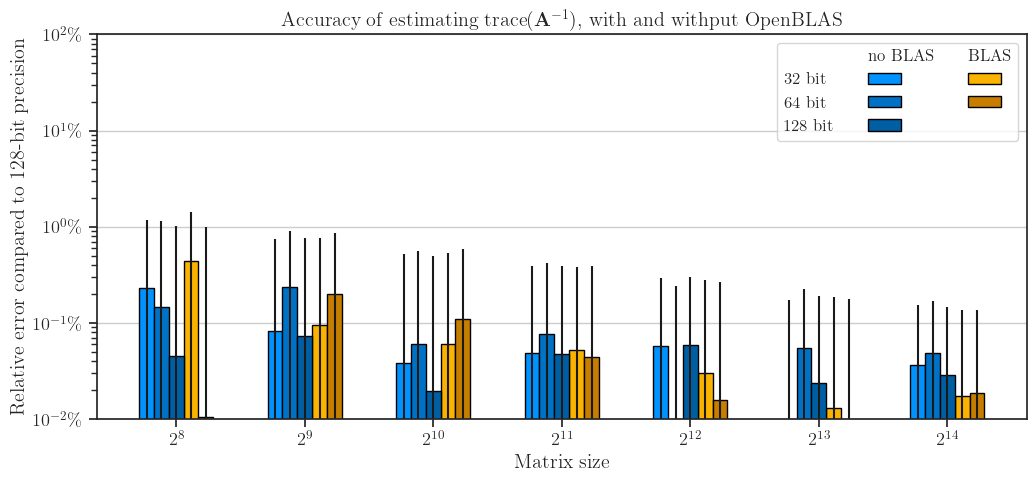

In [5]:
## Plotting Elapsed time vs Matrix Size
# Note: The errors are computed by comparing with 128-bit with no CBLAS.

# Settings
plot_log = True
intel_color = ['#0093FF', '#0072C6', '#005EA3']    # corresponding to 32-bit, 64-bit, and 128-bit
intel_blas_color = ['#FAB300', '#C77E00']          # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                       # corresponding to 32-bit, 64-bit, and 128-bit

# Remove some data
cpu_data_results_ = cpu_data_results.copy()
cpu_blas_data_results_ = cpu_blas_data_results.copy()

#remove_indices = [0, 1, 2]
remove_indices = []

for index in remove_indices[::-1]:
    del cpu_data_results_[index]
    del cpu_blas_data_results_[index]


# Initialize arrays
num_data = len(cpu_data_results_)
num_types = 3   # correspondng to 32-bit, 64-bit, and 128-bit
matrix_size = numpy.zeros((num_data, ), dtype=int)
data_type = numpy.zeros((num_types, ), dtype=int)
cpu_trace = numpy.zeros((num_data, num_types), dtype=float)
cpu_error = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_trace = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_error = numpy.zeros((num_data, num_types), dtype=float)

cpu_blas_trace[:] = numpy.nan
cpu_blas_error[:] = numpy.nan


for data_index in range(num_data):

    cpu_data_result = cpu_data_results_[data_index]
    cpu_type_results = cpu_data_result['type_results']
    
    if data_index < len(cpu_blas_data_results):
        cpu_blas_data_result = cpu_blas_data_results_[data_index]
        cpu_blas_type_results = cpu_blas_data_result['type_results']

    matrix_size[data_index] = cpu_type_results[0]['result']['info']['matrix']['size']

    # Iterate over 32-bit, 64-bit and 128-bit data
    for type_index in range(len(cpu_type_results)):

        cpu_type_result = cpu_type_results[type_index]
        data_type[type_index] = cpu_type_result['data_type']
        cpu_results = cpu_type_result['result']

        cpu_trace[data_index, type_index] = cpu_results['trace']
        cpu_error[data_index, type_index] = cpu_results['info']['error']['absolute_error']
        
        if type_index < len(cpu_blas_type_results):
            cpu_blas_type_result = cpu_blas_type_results[type_index]
            cpu_blas_results = cpu_blas_type_result['result']

            if len(cpu_blas_results) > 0:
                cpu_blas_trace[data_index, type_index] = cpu_blas_results['trace']
                cpu_blas_error[data_index, type_index] = \
                        cpu_blas_results['info']['error']['absolute_error']


# Relative comparison w.r.t 128-bit (in percent)
cpu_trace_relative = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_trace_relative = numpy.zeros((num_data, num_types), dtype=float)
cpu_error_relative = numpy.zeros((num_data, num_types), dtype=float)
cpu_blas_error_relative = numpy.zeros((num_data, num_types), dtype=float)
percent = 100.0

# Analytic solution
benchmark_trace = analytic_traceinv(cpu_benchmark_result['matrix'])

for data_index in range(num_data):
    #benchmark_trace = numpy.abs(cpu_trace[data_index, -1])
    # benchmark_cpu_blas_trace = numpy.abs(cpu_blas_trace[data_index, -1])
    
    for type_index in range(num_types):
        cpu_trace_relative[data_index, type_index ] = percent * \
            numpy.abs(cpu_trace[data_index, type_index] - benchmark_trace[data_index]) / \
            benchmark_trace[data_index]
        cpu_blas_trace_relative[data_index, type_index ] = percent * \
            numpy.abs(cpu_blas_trace[data_index, type_index] - benchmark_trace[data_index]) / \
            benchmark_trace[data_index]
        cpu_error_relative[data_index, type_index ] = percent * \
            numpy.abs(cpu_error[data_index, type_index]) / benchmark_trace[data_index]
        cpu_blas_error_relative[data_index, type_index ] = percent * \
            numpy.abs(cpu_blas_error[data_index, type_index]) / benchmark_trace[data_index]
    
# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
abscissa = matrix_size  

#width = 0.17
width = 0.08
#logsp = numpy.logspace(-width/1.55, width/1.55, 4)
logsp = numpy.logspace(-width/1.15, width/1.15, 5)
cpu_widths = logsp[:3]
cpu_blas_widths = logsp[3:]

for type_index in range(num_types):
    
    type_ = data_type[type_index]
    x = cpu_widths[type_index]*abscissa
    ax.bar(x, cpu_trace_relative[:, type_index], yerr=cpu_error_relative[:, type_index],
           width=width*x, edgecolor='black',
       color=intel_color[type_index], label='no BLAS ' + str(type_) + '-bit')
    
    if type_ != 128 and type_ != 0:
        x = cpu_blas_widths[type_index]*abscissa
        ax.bar(x, cpu_blas_trace_relative[:, type_index], yerr=cpu_blas_error_relative[:, type_index],
               width=width*x, edgecolor='black',
           color=intel_blas_color[type_index], label='BLAS ' + str(type_) + '-bit')

        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
#handles = [extra, extra, extra,
#           extra, handles[0], handles[2], 
#           extra, handles[1], handles[3]]
#labels = ["", "32 bit", "64 bit",
#          "no BLAS", "", "",
#          "BLAS", "", ""]
handles = [extra, extra, extra, extra,
           extra, handles[0], handles[2], handles[4], 
           extra, handles[1], handles[3], extra]
labels = ["", "32 bit", "64 bit", "128 bit",
          "no BLAS", "", "", "",
          "BLAS", "", "", ""]
#handles = [handles[0], handles[2], handles[4], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[1], labels[3]]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2)
ax.legend(handles, labels, loc='upper right', ncol=3, handletextpad = -2, fontsize='small')
    
plt.xscale('log', base=2)
plt.yscale('log', base=10)

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.set_xticks(matrix_size)

#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))
ax.set_ylim([1e-2, 1e2])
#ax.set_ylim([0, 30])


ax.set_ylabel('Relative error compared to 128-bit precision')
ax.set_title('Accuracy of estimating $\mathrm{trace}(\mathbf{A}^{-1})$, with and withput OpenBLAS')

ax.set_xlabel('Matrix size')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'benchmark_openblas_dense_accuracy' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

In [6]:
data_index = 3

print('32-bit')
print(cpu_data_results[data_index]['type_results'][0]['cpu_results'][0]['trace'])
print(cpu_data_results[data_index]['type_results'][0]['cpu_results'][1]['trace'])
print(cpu_data_results[data_index]['type_results'][0]['cpu_results'][2]['trace'])
print('\n64-bit')
print(cpu_data_results[data_index]['type_results'][1]['cpu_results'][0]['trace'])
print(cpu_data_results[data_index]['type_results'][1]['cpu_results'][1]['trace'])
print(cpu_data_results[data_index]['type_results'][1]['cpu_results'][2]['trace'])
print('\n128-bit')
print(cpu_data_results[data_index]['type_results'][2]['cpu_results'][0]['trace'])
print(cpu_data_results[data_index]['type_results'][2]['cpu_results'][1]['trace'])
print(cpu_data_results[data_index]['type_results'][2]['cpu_results'][2]['trace'])

32-bit


KeyError: 'cpu_results'

In [ ]:
data_index = 3

print('32-bit')
print(cpu_blas_data_results[data_index]['type_results'][0]['cpu_results'][0]['trace'])
print(cpu_blas_data_results[data_index]['type_results'][0]['cpu_results'][1]['trace'])
print(cpu_blas_data_results[data_index]['type_results'][0]['cpu_results'][2]['trace'])
print('\n64-bit')
print(cpu_blas_data_results[data_index]['type_results'][1]['cpu_results'][0]['trace'])
print(cpu_blas_data_results[data_index]['type_results'][1]['cpu_results'][1]['trace'])
print(cpu_blas_data_results[data_index]['type_results'][1]['cpu_results'][2]['trace'])